In [584]:
# loading the necessary libraries
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings("ignore")
from xgboost import plot_importance

## INDEX

###  <a href='#1'>1. FEATURE ENGINEERING</a>

###  <a href='#2'>2. MODEL TRAINING</a>

    *  <a href='#2.1'>2.1 LOGSITIC REGRESSION</a>

    *  <a href='#2.2'>2.2 DECISION TREE</a>

    *  <a href='#2.3'>2.3 XG BOOST</a>

###  <a href='#3'>3. INFERENCES FROM MODEL TRAINING</a>

###  <a href='#4'>4. IDENTIFYING HIGH LOAN DEFAULTS</a>

###  <a href='#5'>5. POTENTIAL FUTURE IMPROVEMENTS</a>

###  <a href='#6'>6. TEST SET</a>


<a id='1'></a>

## 1. FEATURE ENGINEERING


### Based on our eda I would be trying out following additional feature engineering on top of the feautures avaiable and later check how they perform during model training


* loan amount w.r.t annual income
* ratio of total open accounts
* EMI of customer (loan amount/term)
* total coll amount 
* loan amount w.r.t total curr balance
* total interest payble on loan (interest times loan amount)
* converting last week pay,emp_length into numerical values


In [725]:
# reading the required files
import os
path = 'D:\Dataset\ML_Artivatic_dataset\ML_Artivatic_dataset'
os.chdir(path)
train = pd.read_csv('train_indessa.csv')

In [726]:
def fillna(df):
    df.fillna(df.select_dtypes(['int32','int64','float32','float64']).median().iloc[0], inplace=True)
    df.fillna(df.select_dtypes(['object']).mode().iloc[0], inplace=True) 
    return df

In [727]:
# filling null values, filling numerical values with median and categorical values with mode
train = fillna(train)

In [728]:
def get_features(df):
    '''this function creates the additional features and returns the final dataframe'''
    df['term'] = df['term'].map({'36 months':36,'60 months':60})
    df['loan_amnt_wrt_inc'] = np.round(df['loan_amnt']/df['annual_inc']*100,1)
    df['ratio_open_accounts'] = np.round(df['open_acc']/df['total_acc']*100,1)
    df['interest_payble'] = np.round(df['int_rate']*df['loan_amnt']/100,1)
    df['EMI'] = np.round((df['loan_amnt']+df['interest_payble'])/(df['term'])*100,1)
    df['last_week_pay'] = df['last_week_pay'].str.extract('(\d{1,5})')
    df['last_week_pay'].fillna(df['last_week_pay'].mode().values[0],inplace=True)
    df['last_week_pay'] = df['last_week_pay'].astype(int)
    df['emp_length'] = df['emp_length'].str.extract('(\d{1,3})')#.astype(int)
    df['emp_length'].fillna(df['emp_length'].mode().values[0],inplace=True)
    df['emp_length'] = df['emp_length'].astype(int)
    # to handle divide by 0 cases for derived features where we are dividing by other columns
    df = df.replace([np.inf, -np.inf], -1)
    return df

In [729]:
def remove_cols(df,is_train):
    '''this function removes columns with high number of null values,highly correlated features and categorical features with single category values mostly'''
    rem_cols = ['verification_status_joint','desc','mths_since_last_record','funded_amnt','funded_amnt_inv','application_type','pymnt_plan','emp_title','recoveries','collection_recovery_fee','collections_12_mths_ex_med','zip_code','batch_enrolled','title']
    final_cols = list(set(train.columns.tolist()) - (set(rem_cols)))
    if is_train==False:
        final_cols.remove('loan_status')
    df = df[final_cols]
    return df,final_cols

In [730]:
def get_cat_num_cols(df):
    '''this function returns the categorical and numerical features based on the datatypes'''
    cat_cols = list(df.select_dtypes(['object']).columns)
    num_cols = list(df.select_dtypes(['int32','int64','float32','float64']).columns)
    num_cols.remove('member_id')
    if loan_status in num_cols:
        num_cols.remove('loan_status')
    return cat_cols,num_cols

In [1]:
# getting additional features and fetching numerial and categorical feature names seperately
train = get_features(train)
train,final_columns = remove_cols(train,is_train=True)
cat_cols,num_cols = get_cat_num_cols(train)

In [ ]:
# shuffling the data
train = train.sample(frac=1)

In [593]:
# Splitting the data into train and test set
train_features, test_features, train_y, test_y = train_test_split(train[final_columns],train['loan_status'],test_size = 0.25)

In [594]:
# Creating count vectorizers for each category colums to one hot encode them later
count_vects = {}
for col in cat_cols:    
    vect = CountVectorizer(analyzer = 'char',token_pattern = r"(?u)\b\w+\b")
    vect.fit(train_features[col])
    count_vects.update({col:vect}) 

In [595]:
def get_encoded_category_features(df,cat_cols,count_vects):
    '''this function returns one hot encoded categorical features'''
    df_ls = []
    for col in cat_cols:
        encoded_vect = count_vects[col].transform(df[col])
        temp_df = pd.DataFrame(encoded_vect.toarray(),index = df.index).add_prefix('{}_'.format(col))
        df_ls.append(temp_df)
    return pd.concat(df_ls,axis=1)      

In [748]:
# Normalizing the numerical features since during modelling phase we would try out models like Logisitc Regression which could get affected by scale of features
scaler = MinMaxScaler()
scaler.fit(train_features[num_cols])   
def get_normalized_features(df,num_cols,scaler):
    '''this function takes the numerical columns and returns them in their normalized form'''
    normalized_features = scaler.transform(df[num_cols])
    normalized_features = pd.DataFrame(normalized_features,index = df.index,columns=num_cols)
    normalized_features[['member_id']] = df[['member_id']]
    return normalized_features

In [597]:
# getting normalized numerical features and categorical features and combining them into final dataframe
train_num = get_normalized_features(train_features,num_cols,scaler)
test_num = get_normalized_features(test_features,num_cols,scaler)
train_cat = get_encoded_category_features(train_features,cat_cols,count_vects)
test_cat = get_encoded_category_features(test_features,cat_cols,count_vects)
final_train = pd.concat([train_num,train_cat],axis=1)
final_test = pd.concat([test_num,test_cat],axis=1)

In [598]:
final_train.shape,final_test.shape

((399321, 119), (133107, 119))

<a id='2'></a>

## 2. MODEL TRAINING

In [ ]:
# GETTING THE FINAL COLUM LIST FOR TRANING
cols = list(set(final_train.columns.tolist()) - (set(['member_id','loan_status'])))

<a id='2.1'></a>

### 2.1 LOGISTIC REGRESSION

for c = 1e-06
auc roc : 0.7100809786639026
for c = 1e-05
auc roc : 0.719373839047887
for c = 0.0001
auc roc : 0.7306498506344627
for c = 0.001
auc roc : 0.7509912632278198
for c = 0.01
auc roc : 0.7929828152362847
for c = 0.1
auc roc : 0.8142187847814719
for c = 1
auc roc : 0.8166226666388094
for c = 10
auc roc : 0.8171139227479673
for c = 100
auc roc : 0.8173477448118415


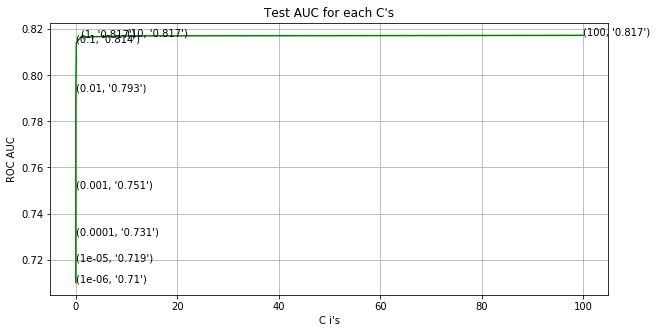

For values of best C =  100 The train roc auc is: 0.8164413985274885
For values of best C =  100 The test roc auc is: 0.8173477448118415


In [614]:
# TRYING OUT LOGISTIC REGRESSION FOR VARIOUS OF REGULARIZATION PARAMETERS AND PLOTTING THE PERFORMANCE ON TEST SET 
c = [10 ** x for x in range(-6, 3)]
test_auc_array = []
for i in c:
    print("for c =", i)
    clf = LogisticRegression(C=i)
    clf.fit(final_train[cols], train_y)
    clf_probs = clf.predict_proba(final_test[cols])
    test_auc_array.append(roc_auc_score(test_y, list(map(lambda row:row[1],clf_probs))))
    print("auc roc :",roc_auc_score(test_y,list(map(lambda row:row[1],clf_probs)))) 

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(c, test_auc_array,c='g')

for i, txt in enumerate(np.round(test_auc_array,3)):
    ax.annotate((c[i],str(txt)), (c[i],test_auc_array[i]))
plt.grid()
plt.title("Test AUC for each C's")
plt.xlabel("C i's")
plt.ylabel("ROC AUC")
plt.show()
best_c = np.argmax(test_auc_array)
logreg_clf = LogisticRegression(C= c[best_c], random_state=42)
logreg_clf.fit(final_train[cols], train_y)
predict_y = logreg_clf.predict_proba(final_train[cols])
predict_y = list(map(lambda row:row[1],predict_y))
print('For values of best C = ', c[best_c], "The train roc auc is:",roc_auc_score(train_y, predict_y))
predict_y = logreg_clf.predict_proba(final_test[cols])
predict_y = list(map(lambda row:row[1],predict_y))
print('For values of best C = ', c[best_c], "The test roc auc is:",roc_auc_score(test_y, predict_y))

<a id='2.2'></a>

### 2.2 DECISION TREE

for minimum samples for split = 2
auc roc : 0.750412297826667
for minimum samples for split = 3
auc roc : 0.7687485795836494
for minimum samples for split = 5
auc roc : 0.7914795434694611
for minimum samples for split = 10
auc roc : 0.8170673265145605
for minimum samples for split = 15
auc roc : 0.8292917720999092
for minimum samples for split = 20
auc roc : 0.8350405756663293
for minimum samples for split = 30
auc roc : 0.8409792032570726
for minimum samples for split = 35
auc roc : 0.8428248520507391
for minimum samples for split = 40
auc roc : 0.8447076426785866
for minimum samples for split = 50
auc roc : 0.8475839399723035
for minimum samples for split = 100
auc roc : 0.8435768941766411


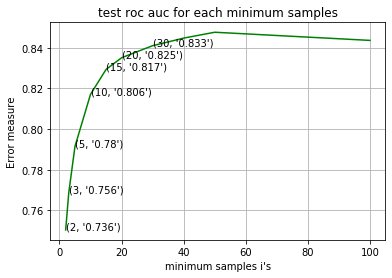

For values of best min samples =  9 The train auc is: 0.907866536297141
For values of best min samples =  9 The test auc is: 0.8474409305288768


In [615]:
# FITTING A DECISION TREE FOR VARIOUS VALUES OF MINIMUM SAMPLES AND PLOTTING PERFORMANCES
min_split_samples = [2,3,5,10,15,20,30,35,40,50,100]
roc_auc_array = []
for i in min_split_samples:
    print("for minimum samples for split =", i)
    clf = DecisionTreeClassifier(min_samples_leaf=i)
    clf.fit(final_train[cols], train_y)
    clf_probs = clf.predict_proba(final_test[cols])
    roc_auc_array.append(roc_auc_score(test_y, list(map(lambda row:row[1],clf_probs))))
    print("auc roc :",roc_auc_score(test_y,list(map(lambda row:row[1],clf_probs)))) 

fig, ax = plt.subplots()
ax.plot(min_split_samples,roc_auc_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((min_split_samples[i],str(txt)), (min_split_samples[i],roc_auc_array[i]))
plt.grid()
plt.title("test roc auc for each minimum samples")
plt.xlabel("minimum samples i's")
plt.ylabel("Error measure")
plt.show()


best_min_samples = np.argmax(roc_auc_array)
dt_clf = DecisionTreeClassifier(min_samples_leaf = min_split_samples[best_min_samples])
dt_clf.fit(final_train[cols], train_y)

pred = dt_clf.predict_proba(final_train[cols])
pred = list(map(lambda row:row[1],pred))
print('For values of best min samples = ',best_min_samples, "The train auc is:",roc_auc_score(train_y, pred))
pred = dt_clf.predict_proba(final_test[cols])
pred = list(map(lambda row:row[1],pred))
print('For values of best min samples = ', best_min_samples, "The test auc is:",roc_auc_score(test_y, pred))

<a id='2.3'></a>

### 2.3 XGBOOST

Due to resource constraint I am not tuning the hyperparameters of xgboost and going with some tentative hyperparameters.

In [617]:
from xgboost import XGBClassifier, plot_importance,to_graphviz
param = {'max_depth':5,'n_estimators':300}
xgb = XGBClassifier(**param)
xgb.fit(final_train[cols],train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [621]:
pred = xgb.predict_proba(final_train[cols])
pred = list(map(lambda row:row[1],pred))
print("The train auc is  : ", roc_auc_score(train_y, pred))
pred = xgb.predict_proba(final_test[cols])
pred = list(map(lambda row:row[1],pred))
print("The test auc is  : ", roc_auc_score(test_y, pred))

The train auc is  :  0.942320951962552
The test auc is  :  0.9268408375357639


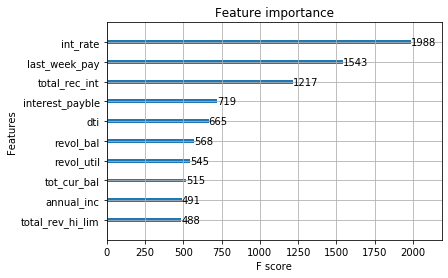

In [782]:
plot_importance(xgb,max_num_features = 10)

<a id='3'></a>

## 3. INFERENCES FROM MODEL TRAINING

* Tree Based Algorithm seems to work better as compared to Logistic Regression probably due to the nature of the problem<br><br>

* While Logisitic Regression tries to divide the feature space into two broad regions (assuming binary classification) by finding the hyperplane which best segregrates the classes wheras Decision Tree tries to break the feature space into smaller regions by setting thresholds across features (conditions) eventually finding set of points which are pure i.e have same classes<br><br>  

* In this case intuitvely also it seems finding these chunk of good borrowers/bad borrowers is eventually __based on a set of rules/conditions_ for example like a customer having high number enquriries recently, having defaults in other loans in the past, having high exisiting debts is tend to default more and Decison Trees are ideal to find these set of rules/conditions__<br><br>

* XGBoost gave the best roc-auc (0.926) probably since it is an ensemble technique involving decision trees (a set sequential trees are present where each tree learns from the error of previous trees) hence it was able to capture some potential complex patterns which were missed by a single decision tree.<br><br>

* Training and test peformance metrics are almost similar in all the models suggesting our models are not facing problem of overfitting/underfitting (Decision Tree was facing problem of overfitting slightly which was improved boosting)<br><br>

* Looking at the feature importances it seems __interest rate on the loan is the biggest indicator of defaults, which kind of makes sense as well higher interest rate means more riskier the customer__, apart from the customers exisiting liability ratio(dti) was also quite important and one of the derived features interest payble was in top 5 probably becasuse int_rate alone was the strongest feature hence featured derived from it also help high feature importance

<a id='4'></a>

## 4. IDENTIFYING HIGH LOAN DEFAULTS

As mentioned in our problem statement high loan amount defaults are more riskier hence the bank wants to perform an additional scrutiny on high loan amount applications (>=20000), below is the strategy that I am going to try out

__In order for model to specifically indentify these high loan defaults well, in the training phase we will specifically oversample these high loan defaults so that model could get to see more of these cases and learn potential high loan default patterns better__

In [622]:
#Let us first look at overall performance of our model and performance across loans>20k specifically

In [641]:
high_inc_indexes = train[(train.index.isin(final_test.index))&(train['loan_amnt']>=20000)].index
high_inc_features = final_test[final_test.index.isin(high_inc_indexes)]
high_inc_target = test_y[test_y.index.isin(high_inc_indexes)]

In [644]:
pred = xgb.predict_proba(final_test[cols])
pred = list(map(lambda row:row[1],pred))
print("The test auc for overall test set  : ", roc_auc_score(test_y, pred))

pred = xgb.predict_proba(high_inc_features[cols])
pred = list(map(lambda row:row[1],pred))
print("The test auc is for high loan sizes(>=20000)  : ", roc_auc_score(high_inc_target, pred))

The test auc for overall test set  :  0.9268408375357639
The test auc is for high loan sizes(>=20000)  :  0.9148094405852081


###  AUC across high loan size population is slightly lower as compared to overall, let us try to see if we could improve it

In [652]:
# fetching indexes of high loan defaults from train dataset
high_inc_default_in_train_indexes = train[(train.index.isin(final_train.index))&(train['loan_amnt']>=20000)&(train['loan_status']==1)].index
additional_features = final_train[final_train.index.isin(high_inc_default_in_train_indexes)]
additional_labels = train_y[train_y.index.isin(high_inc_default_in_train_indexes)]

### Let us oversample our training data with these high loan defaults and retrain the model on this oversampled training set

In [672]:
# oversampling the training data with high loan defaults
oversampled_train = pd.concat([final_train,additional_features],axis=0)
oversampled_train_y = pd.concat([train_y,additional_labels],axis=0)

In [679]:
# retraining our xgboost with the oversampled data
param = {'max_depth':5,'n_estimators':300}
xgb = XGBClassifier(**param)
xgb.fit(oversampled_train[cols],oversampled_train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [680]:
pred = xgb.predict_proba(high_inc_features[cols])
pred = list(map(lambda row:row[1],pred))
print("The test auc is for high loan sizes(>=20000)  : ", roc_auc_score(high_inc_target, pred))

The test auc is for high loan sizes(>=20000)  :  0.9161370239752924


### Even though not significant but there was a slight increase in auc of the test set with loan amount>=20000 

<a id='5'></a>

## 5. POTENTIAL FUTURE IMPROVEMENTS

* Instead of repeating points __new synthetic points__ could be generated using SMOTE <br><br>
* A seperate model could be trained on population with loan ticket size >=20000 <br><br>
* Two models could be trained one on overall data and one on population>=20000 and __later stacked together by combining both model probabilities using a logistic regression or a decision tree__ to get a final prediction probability <br><br>
* Revisit the removed features, combine exisiting important features and generate more derived features in feature engineering

<a id='6'></a>

## 6. TEST SET

In [2]:
#Here let us run the featurization code and model on the test et given for submission

In [775]:
test = pd.read_csv('test_indessa.csv')

In [776]:
# getting final test features
test = fillna(test)
test = get_features(test)
test,_ = remove_cols(test,is_train=False)
final_test_num = get_normalized_features(test,num_cols,scaler)
final_test_cat = get_encoded_category_features(test,cat_cols,count_vects)
submission_test = pd.concat([final_test_num,final_test_cat],axis=1)

In [777]:
# getting predicited probabilities from our xgboost model
pred = xgb.predict_proba(submission_test[cols])
pred = list(map(lambda row:row[1],pred))

In [778]:
# saving final submission
submission_test['loan_status'] = pred
submission[['member_id','loan_status']].to_csv(r'submission.csv')